<a href="https://colab.research.google.com/github/melanieyes/diffusion-model/blob/main/Denoising_Diffusion_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torch

# Matrix 1
image_1 = torch.tensor([
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 0],
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

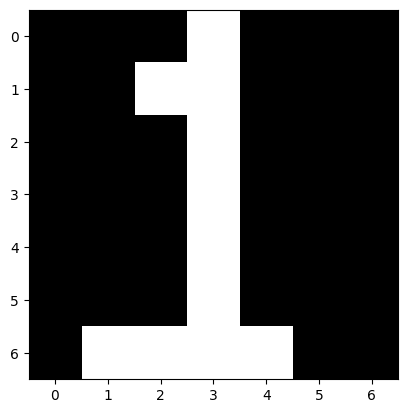

In [ ]:
plt.imshow(image_1[0][0], cmap='gray')
plt.show()

In [ ]:
#param setting
timesteps = 10
beta_start, beta_end = 0.0001, 0.02

# beta schedule
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# constant value
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [ ]:
import torch.nn as nn

class SimpleDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.time_embed = nn.Linear(1, 1)
        self.decoder = nn.ConvTranspose2d(1, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        x_encoded = self.encoder(x)
        t_embed = self.time_embed(t.unsqueeze(-1).float())  # [B, 1]
        t_embed = t_embed.view(-1, 1, 1, 1)
        out = x_encoded + t_embed
        return self.decoder(out)

In [ ]:
# init model
model = SimpleDDPM()

# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
x0 = image_1

In [ ]:
# Forward diffusion
trajectories = [x0]
for t in range(timesteps):
    # add noise
    eps = torch.randn_like(x0)

    # add noise to image
    x_t = (
        sqrt_alphas_cumprod[t] * x0 +
        sqrt_one_minus_alphas_cumprod[t] * eps
    )

    trajectories.append(x_t)
trajectories

[tensor([[[[0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 1., 1., 1., 1., 0., 0.]]]]),
 tensor([[[[ 4.5234e-03, -6.6576e-03, -2.2093e-02,  1.0012e+00, -3.8542e-03,
             1.7829e-03, -1.8914e-03],
           [-5.5222e-03,  1.2164e-04,  1.0060e+00,  1.0109e+00, -1.0988e-02,
             8.9378e-03, -5.0403e-03],
           [-4.8682e-03, -1.9341e-03, -7.6662e-03,  1.0038e+00, -4.2574e-03,
            -1.9563e-03, -8.3869e-04],
           [ 8.2516e-04, -2.7763e-03,  1.0541e-02,  9.9407e-01,  8.7664e-03,
            -1.9140e-02, -2.0622e-03],
           [-3.6652e-03,  5.5705e-03, -7.8998e-03,  9.9824e-01,  2.1109e-03,
             8.6798e-03, -1.6556e-03],
           [-3.7293e-03,  1.0856e-02, -2.5312e-02,  9.9229e-01, -1.4025e-02,
            -4.8207e-03,  1.4736e-02],
           [-

In [ ]:
# training model
losses = []
steps = 5000
model.train()

for step in range(steps):
    # random timestep
    t = torch.randint(0, timesteps, (1,))

    # noise
    eps = torch.randn_like(x0)

    # add noise to the picture
    x_t = (
        sqrt_alphas_cumprod[t] * x0 +
        sqrt_one_minus_alphas_cumprod[t] * eps
    )

    # noise prediction
    pred_eps = model(x_t, t)

    # loss
    loss = loss_fn(pred_eps, eps)

    # update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # print loss
    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.6f}")

Step 0, Loss: 0.967770
Step 500, Loss: 0.778472
Step 1000, Loss: 0.577756
Step 1500, Loss: 0.986187
Step 2000, Loss: 0.501112
Step 2500, Loss: 0.574324
Step 3000, Loss: 0.349875
Step 3500, Loss: 0.428341
Step 4000, Loss: 1.170144
Step 4500, Loss: 0.609440


In [ ]:
# Reverse process
model.eval()
x_t = trajectories[-1]  # the last noise pic
reverse_trajectory = [x_t]

with torch.no_grad():
    for t in reversed(range(timesteps)):
        # predict
        eps_theta = model(x_t, torch.tensor([t]))

        # param
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        beta_t = betas[t]

        # Compute coefficients
        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)

        # predict
        x_0_pred = coef1 * (x_t - coef2 * eps_theta)

        # x_0_pred
        x_0_pred = torch.clamp(x_0_pred, min=0, max=1)

        # compute mean
        if t > 0:
            noise = torch.randn_like(x_t)
            sigma = torch.sqrt(beta_t)
            x_t = coef1 * (x_t - coef2 * eps_theta) + sigma * noise
        else:
            x_t = x_0_pred

        reverse_trajectory.append(x_t)

In [ ]:
reverse_trajectory

[tensor([[[[ 7.2297e-02,  2.6425e-01, -4.1056e-01,  1.4596e+00,  6.1736e-01,
            -9.9813e-02,  2.5714e-01],
           [-2.6396e-01, -5.1502e-02,  9.7337e-01,  9.0687e-01,  3.2856e-02,
             4.3486e-01,  1.4462e-01],
           [ 1.5389e-01,  1.5211e-01, -2.2648e-01,  8.0106e-01,  1.7015e-01,
             2.0132e-01, -7.8087e-02],
           [-2.3282e-01, -9.0952e-02, -1.2137e-02,  1.5706e+00,  6.8359e-01,
             1.8266e-01,  1.5163e-01],
           [-1.3313e-01, -4.3199e-04,  7.3584e-01,  8.3687e-01, -3.5855e-01,
             2.6338e-01, -1.0212e-01],
           [-9.4638e-02,  8.9605e-02, -1.8337e-01,  1.1593e+00,  2.3995e-01,
            -2.3182e-01, -3.3567e-01],
           [ 1.9801e-01,  8.7932e-01,  7.5763e-01,  6.8646e-01,  1.3647e+00,
            -4.3221e-01, -1.3885e-02]]]]),
 tensor([[[[ 0.0805,  0.2996, -0.4075,  1.2241,  0.7845, -0.1569,  0.2097],
           [-0.0655,  0.0778,  0.8424,  1.2329, -0.0114,  0.5384,  0.1630],
           [ 0.2703,  0.1276, -0

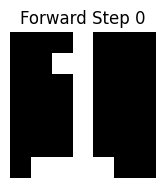

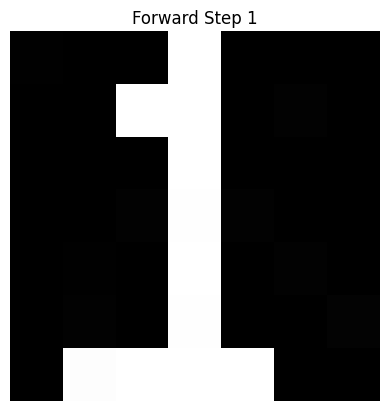

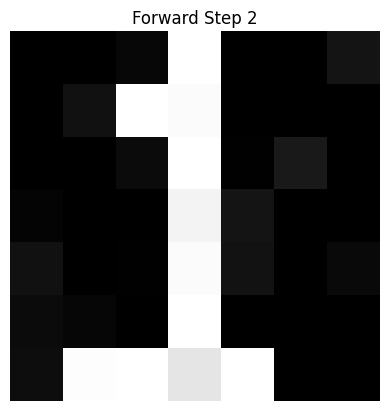

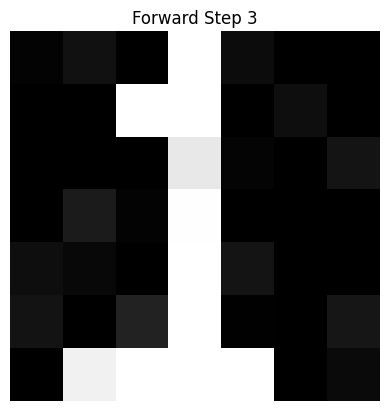

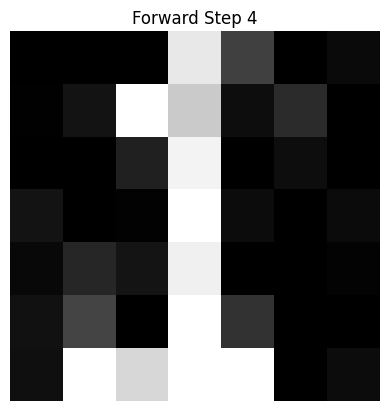

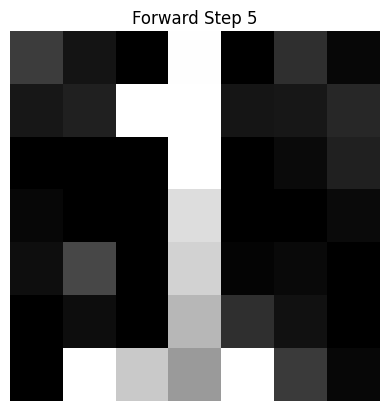

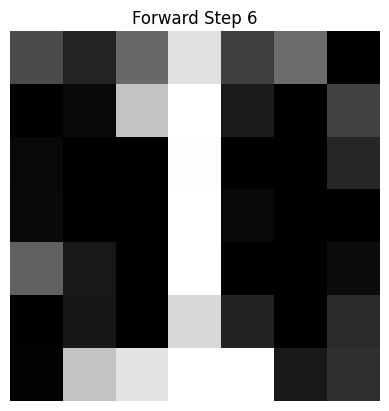

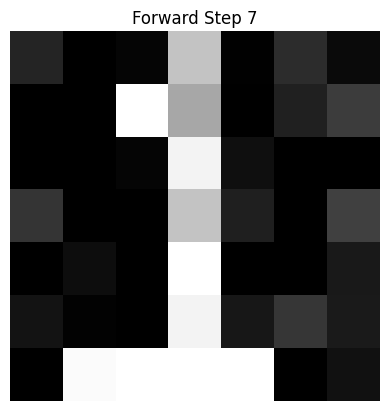

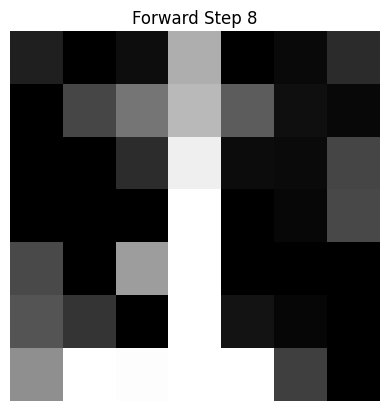

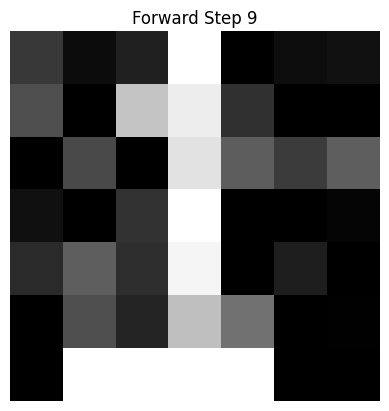

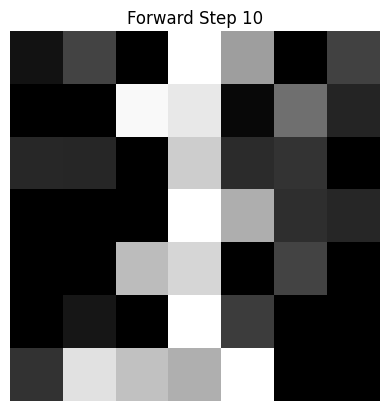

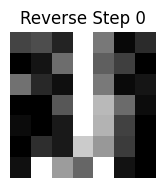

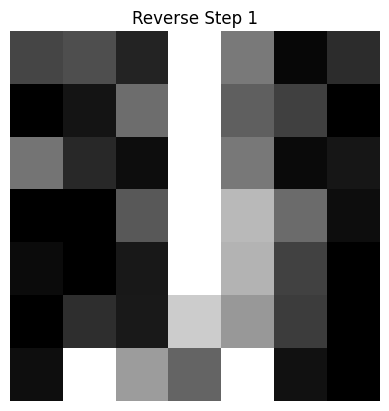

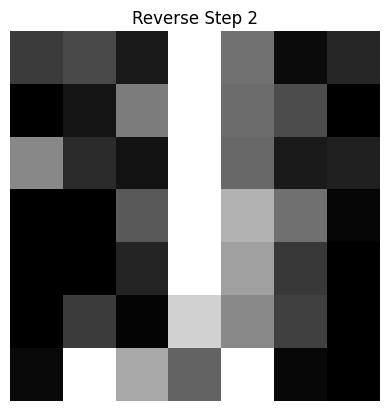

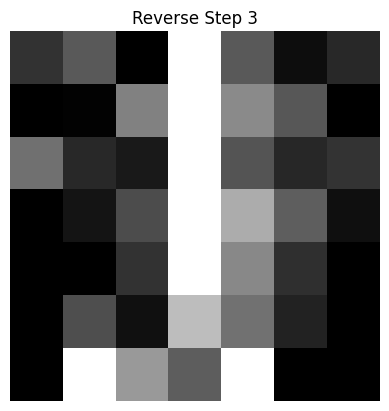

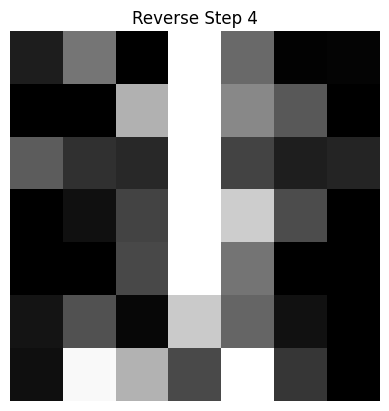

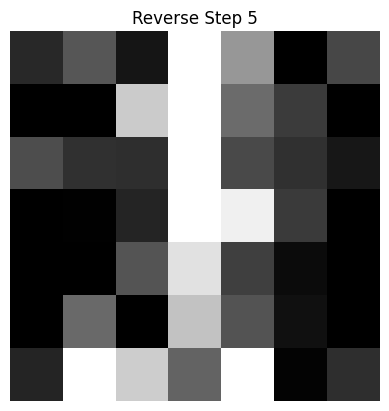

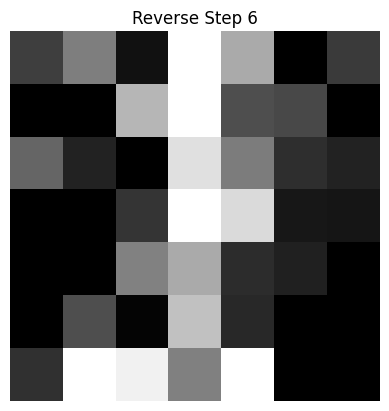

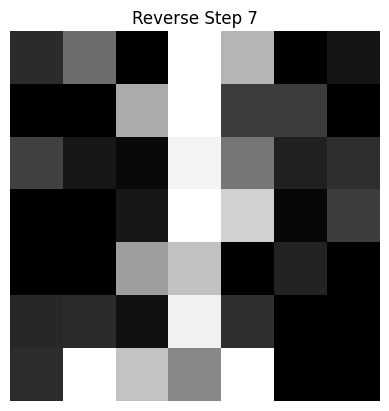

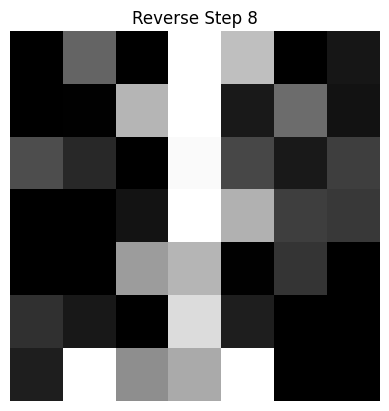

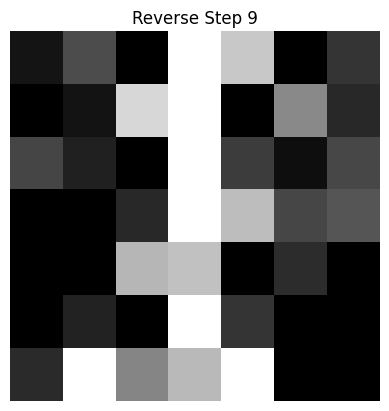

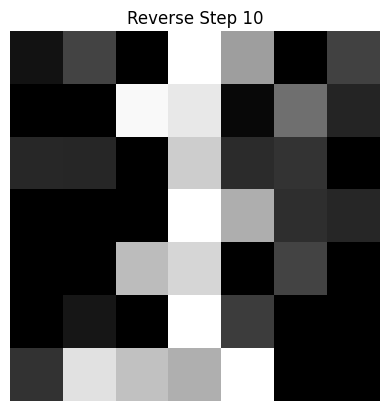

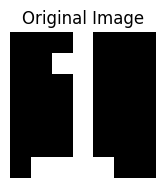

In [ ]:
# Forward trajectory
plt.subplot(1, 3, 1)
for i, img in enumerate(trajectories):
    plt.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Forward Step {i}')
    plt.axis('off')
    plt.show()

# Reverse trajectory
plt.subplot(1, 3, 2)
for i, img in enumerate(list(reversed(reverse_trajectory))):
    plt.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Reverse Step {i}')
    plt.axis('off')
    plt.show()

# compare original image
plt.subplot(1, 3, 3)
plt.imshow(x0.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.title('Original Image')
plt.axis('off')
plt.show()